In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import string
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# from transformers import pipeline
import optuna
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import lightgbm as lgbm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import  CountVectorizer #bag-of-words vectorizer 

# Bert
import torch
from transformers import BertTokenizer, BertModel
from torch import nn
from tqdm import tqdm

#%matplotlib inline
%run ./Metrics.py
#%run ./ESE527_project_setup.ipynb
#%run ./Text_Normalization_Function.ipynb #defining text normalization function

In [2]:
print("PyTorch version: ", torch.__version__)  # 打印PyTorch版本
print("CUDA available : ", torch.cuda.is_available())  # 检查CUDA是否可用
print('There are %d GPU(s) available.' % torch.cuda.device_count())
if torch.cuda.is_available():
    device = 'cuda:0' 
else:
    device = 'cpu'

PyTorch version:  2.4.1+cu124
CUDA available :  True
There are 1 GPU(s) available.


### Data preprocessing

In [3]:
review_data=pd.read_csv(r"C:\Users\Chuxu\ESE527\googleplaystore_user_reviews.csv")
review_null = pd.DataFrame({'Null Values':review_data.isna().sum().sort_values(ascending=False),
'Percentage Null Values':(review_data.isna().sum().sort_values(ascending=False))/(review_data.shape[0])*(100)})

In [14]:
review_data.shape

(64295, 5)

In [5]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

def categorize_Sentiment(sentiment):
    if sentiment =='Positive' :
        return 2
    elif sentiment == 'Neutral':
        return 1
    elif sentiment == 'Negative':
        return 0
    else:
        return np.nan  
    
def get_data(df,row_number,sentence_len):
    review_data_sample=df.dropna()
    review_data_sample=review_data_sample.iloc[:row_number,] 
    review_data_sample['Rating Interval'] = review_data_sample['Sentiment'].apply(categorize_Sentiment)
    review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].apply(remove_punc_stopword)
    review_data_sample['Translated_Review'] = review_data_sample['Translated_Review'].str.join(' ')
    
    for i in review_data_sample.index:
        if len(review_data_sample['Translated_Review'][i])<=sentence_len:
            review_data_sample=review_data_sample.drop(i)
    Review = review_data_sample["Translated_Review"]
    Rating = review_data_sample["Rating Interval"]
    train_comments, test_comments, train_labels, test_labels  = train_test_split(list(Review), list(Rating), test_size = 0.2, random_state = 68)
    return train_comments, test_comments, train_labels, test_labels

train_comments, test_comments, train_labels, test_labels  = get_data(review_data,10000,30) #选取10000行review数据，从中提取长度大于30的句子作为训练数据。
print("length of train_comments:",len(train_comments)," length of train_comments:",len(test_comments))

length of train_comments: 5716  length of train_comments: 1430


In [6]:
# train_comments = train_comments[0:5]
# train_labels = train_labels[0:5]
# df = pd.DataFrame({
#     'comments': train_comments,
#     'Sentiment': train_labels
# })
# print(df)

#### Tfidf-Vectorizer Method

In [7]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,1)) #(1,2)
feature_matrix_TRAIN = Tfidf_vectorizer.fit_transform(train_comments).astype(float)
feature_matrix_TEST = Tfidf_vectorizer.transform(test_comments)

In [8]:
feature_matrix_TRAIN

<5716x10193 sparse matrix of type '<class 'numpy.float64'>'
	with 97842 stored elements in Compressed Sparse Row format>

#### CountVectorizer + Tfidf-Transformer

In [89]:
# vectorizer = CountVectorizer()
# tf_idf_transformer = TfidfTransformer()
# feature_matrix_TRAIN = tf_idf_transformer.fit_transform(vectorizer.fit_transform(normalized_train_reviews)).toarray()
# feature_matrix_TEST = tf_idf_transformer.transform(vectorizer.transform(normalized_test_reviews)).toarray() 

In [106]:
def objective(trial):
    params = params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 200),
        'boosting_type': trial.suggest_categorical('boosting_type',['gbdt','rf','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(feature_matrix_TRAIN,  train_labels)
    k_folds = 3
    cv_scores = cross_val_score(model, feature_matrix_TRAIN,  train_labels, cv=k_folds, scoring='accuracy')
    return np.mean(cv_scores)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)
# Get the best parameters
best_params = study.best_params
clf_lgbm=lgbm.LGBMClassifier(**best_params)
clf_lgbm.fit(feature_matrix_TRAIN, train_labels)
y_pred_lgbm=clf_lgbm.predict(feature_matrix_TEST)

[I 2024-12-16 22:50:26,624] A new study created in memory with name: no-name-98f3158e-3a4a-4af3-932a-8c0528d38542


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8636042866886962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636042866886962
[LightGBM] [Warning] bagging_fraction is set=0.9556076383824366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556076383824366
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8636042866886962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8636042866886962
[LightGBM] [Warning] bagging_fraction is set=0.9556076383824366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556076383824366
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

[LightGBM] [Warning] feature_fraction is set=0.7271283881703972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7271283881703972
[LightGBM] [Warning] bagging_fraction is set=0.7170294872570473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7170294872570473
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Accuracy: 0.872716894977169
Precision: 0.8763129189929513
Recall: 0.872716894977169
F1 Score: 0.8718551715056809


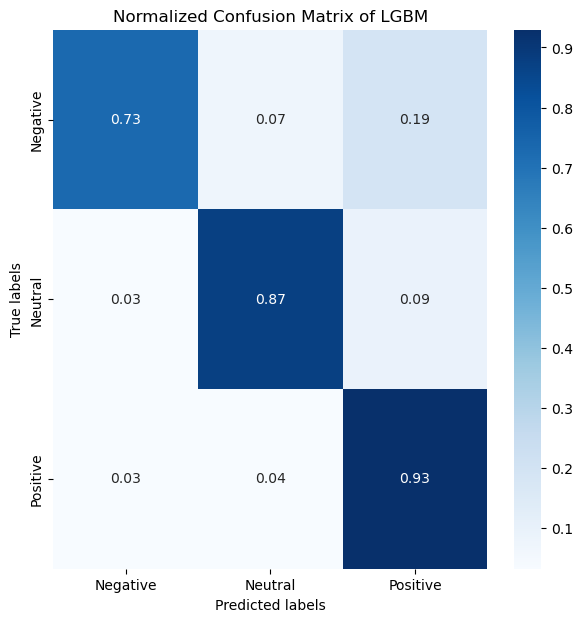

In [107]:
cm(feature_matrix_TEST, test_labels, clf_lgbm,'LGBM',[ 'Negative', 'Neutral','Positive'])

[LightGBM] [Warning] feature_fraction is set=0.7271283881703972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7271283881703972
[LightGBM] [Warning] bagging_fraction is set=0.7170294872570473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7170294872570473
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


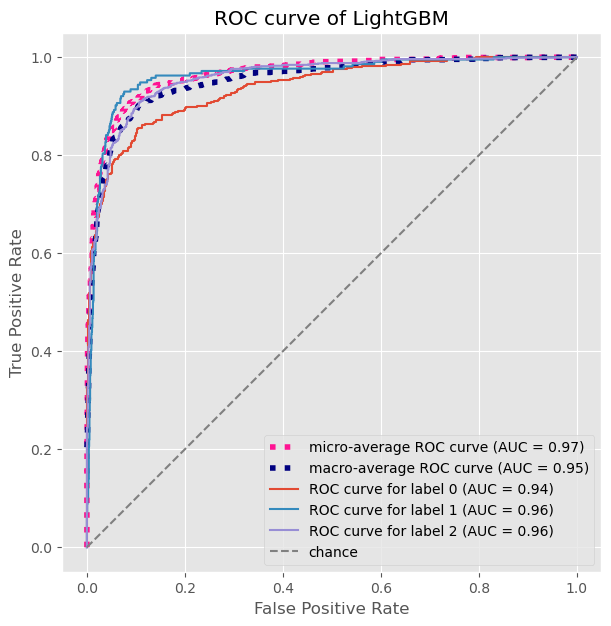

In [111]:
ROC(train_labels,test_labels,feature_matrix_TEST,clf_lgbm,"LightGBM")